In [1]:
import pandas as pd

In [112]:
from fasta_reader import read_fasta

btheta_genome = [item.sequence for item in read_fasta("GCF_000011065.1_ASM1106v1_genomic.fna.gz")][0]
len(btheta_genome)

6260361

In [113]:
large_sv = pd.read_csv("btheta_large_sv.csv")
large_sv

,invertase,start,end,type
0,BT_1041,1315241,1318115,inv
1,BT_1041,1315241,1325103,inv
2,BT_2267,2844579,2847259,inv
3,BT_2267,2838395,2847259,inv
4,BT_3478,4480576,4486382,inv
5,BT_3478,4480576,4502881,inv
6,BT_3478,4480576,4517514,inv
7,BT_3478,4486382,4502881,del
8,BT_3478,4486382,4517514,del
9,BT_3478,4502875,4517514,del


In [114]:
large_sv['sv_length'] = large_sv["end"] - large_sv["start"]

In [115]:
large_sv = large_sv.set_index(["invertase", "start", "end"], drop=False)

In [116]:
large_sv

invertase    start      end type  sv_length
invertase start   end                                                
BT_1041   1315241 1318115   BT_1041  1315241  1318115  inv       2874
                  1325103   BT_1041  1315241  1325103  inv       9862
BT_2267   2844579 2847259   BT_2267  2844579  2847259  inv       2680
          2838395 2847259   BT_2267  2838395  2847259  inv       8864
BT_3478   4480576 4486382   BT_3478  4480576  4486382  inv       5806
                  4502881   BT_3478  4480576  4502881  inv      22305
                  4517514   BT_3478  4480576  4517514  inv      36938
          4486382 4502881   BT_3478  4486382  4502881  del      16499
                  4517514   BT_3478  4486382  4517514  del      31132
          4502875 4517514   BT_3478  4502875  4517514  del      14639

In [117]:
from Bio.Seq import Seq
from Bio.Align import PairwiseAligner

In [118]:
aligner = PairwiseAligner()
aligner.mode = "local"

aligner.open_gap_score = -100000
aligner.extend_gap_score = -100000

aligner.mismatch_score = -9

aligner.match_score = 5

In [119]:
info_dic = []

for i in range(large_sv.shape[0]):
    row = large_sv.iloc[i]
    start_sv = row["start"]
    end_sv = row["end"]
    context = 1000
    
    start_seq1, end_seq1 = start_sv - context, start_sv + context
    start_seq2, end_seq2 = end_sv - context, end_sv + context
    seq1 = btheta_genome[start_seq1 : end_seq1]
    seq2 = btheta_genome[start_seq2 : end_seq2]
    seq2_rev_com = Seq(seq2).reverse_complement()

    alignment = aligner.align(seq1, seq2)[0]
    a = alignment.aligned[0][0][0]
    b = alignment.aligned[0][0][1]
    c = alignment.aligned[1][0][0]
    d = alignment.aligned[1][0][1]

    dic = {
        "DR Coordinate A" : start_seq1 + a,
        "DR Coordinate B" : start_seq1 + b,
        "DR Coordinate C" : start_seq2 + c,
        "DR Coordinate D" : start_seq2 + d,
        "DR Coordinate A relative to sv start" : a - context,
        "DR Coordinate B relative to sv start" : b - context,
        "DR Coordinate C relative to sv end" : c - context,
        "DR Coordinate D relative to sv end" : d - context,
        "DR Length" : b - a,
        "DR1 Sequence" : seq1[a : b],
        "DR2 Sequence" : seq2[c : d],
    }
    
    alignment = aligner.align(seq1, seq2_rev_com)[0]
    a = alignment.aligned[0][0][0]
    b = alignment.aligned[0][0][1]
    c = alignment.aligned[1][0][0]
    d = alignment.aligned[1][0][1]
    
    dic2 = {
        "IR Coordinate A" : start_seq1 + a,
        "IR Coordinate B" : start_seq1 + b,
        "IR Coordinate C" : start_seq2 + (2 * context) - d,
        "IR Coordinate D" : start_seq2 + (2 * context) - c,
        "IR Coordinate A relative to sv start" : a - context,
        "IR Coordinate B relative to sv start" : b - context,
        "IR Coordinate C relative to sv end" : context - d,
        "IR Coordinate D relative to sv end" : context - c,
        "IR Length" : b - a,
        "IR1 Sequence" : seq1[a : b],
        "IR2 Sequence" : seq2[2 * context - d : 2 * context - c],
    }
    
    for k in dic2:
        dic[k] = dic2[k]
    
    info_dic.append(dic)

In [122]:
info_df = pd.DataFrame(info_dic)
info_df.index = large_sv.index
info_df = pd.concat([large_sv, info_df], axis=1)
info_df

invertase    start      end type  sv_length  \
invertase start   end                                                   
BT_1041   1315241 1318115   BT_1041  1315241  1318115  inv       2874   
                  1325103   BT_1041  1315241  1325103  inv       9862   
BT_2267   2844579 2847259   BT_2267  2844579  2847259  inv       2680   
          2838395 2847259   BT_2267  2838395  2847259  inv       8864   
BT_3478   4480576 4486382   BT_3478  4480576  4486382  inv       5806   
                  4502881   BT_3478  4480576  4502881  inv      22305   
                  4517514   BT_3478  4480576  4517514  inv      36938   
          4486382 4502881   BT_3478  4486382  4502881  del      16499   
                  4517514   BT_3478  4486382  4517514  del      31132   
          4502875 4517514   BT_3478  4502875  4517514  del      14639   

                           DR Coordinate A  DR Coordinate B  DR Coordinate C  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315619          1315639          1319082   
                  1325103          1314927          1314946          1325776   
BT_2267   2844579 2847259          2844559          2844576          2847264   
          2838395 2847259          2838373          2838392          2847262   
BT_3478   4480576 4486382          4480108          4480126          4487214   
                  4502881          4480470          4480481          4501961   
                  4517514          4480121          4480135          4517937   
          4486382 4502881          4486378          4486967          4502877   
                  4517514          4486378          4486973          4517510   
          4502875 4517514          4502873          4503471          4517506   

                           DR Coordinate D  \
invertase start   end                        
BT_1041   1315241 1318115          1319102   
                  1325103          1325795   
BT_2267   2844579 2847259          2847281   
          2838395 2847259          2847281   
BT_3478   4480576 4486382          4487232   
                  4502881          4501972   
                  4517514          4517951   
          4486382 4502881          4503466   
                  4517514          4518105   
          4502875 4517514          4518104   

                           DR Coordinate A relative to sv start  ...  \
invertase start   end                                            ...   
BT_1041   1315241 1318115                                   378  ...   
                  1325103                                  -314  ...   
BT_2267   2844579 2847259                                   -20  ...   
          2838395 2847259                                   -22  ...   
BT_3478   4480576 4486382                                  -468  ...   
                  4502881                                  -106  ...   
                  4517514                                  -455  ...   
          4486382 4502881                                    -4  ...   
                  4517514                                    -4  ...   
          4502875 4517514                                    -2  ...   

                           IR Coordinate B  IR Coordinate C  IR Coordinate D  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315240          1318113          1318326   
                  1325103          1315240          1325103          1325436   
BT_2267   2844579 2847259          2844579          2847259          2847324   
          2838395 2847259          2838395          2847259          2847372   
BT_3478   4480576 4486382          4480579          4486378          4486961   
                  4502881          4480579          4502877          4503473   
                  4517514          4480579          4517510          4518092   
          4486382 4502881          4487075        

In [123]:
# sanity check

for i in range(info_df.shape[0]):
    row = info_df.iloc[i]
    A, B, C, D = row["DR Coordinate A"],row["DR Coordinate B"],row["DR Coordinate C"],row["DR Coordinate D"],
    assert(row["DR1 Sequence"] == btheta_genome[A:B])
    assert(row["DR2 Sequence"] == btheta_genome[C:D])
    
    A, B, C, D = row["IR Coordinate A"],row["IR Coordinate B"],row["IR Coordinate C"],row["IR Coordinate D"],
    assert(row["IR1 Sequence"] == btheta_genome[A:B])
    assert(row["IR2 Sequence"] == btheta_genome[C:D])

In [124]:
import nltk

In [125]:
# sanity check

for i in range(info_df.shape[0]):
    row = info_df.iloc[i]
    DR1, DR2, IR1, IR2 = row["DR1 Sequence"],row["DR2 Sequence"],row["IR1 Sequence"],row["IR2 Sequence"],
    
#     print(DR1)
#     print(DR2)
#     print(IR1)
#     print(Seq(IR2).reverse_complement())

    print(nltk.edit_distance(DR1, DR2) / len(DR1))
    print(nltk.edit_distance(IR1, Seq(IR2).reverse_complement()) / len(IR1))

    print()

0.15
0.12206572769953052

0.15789473684210525
0.17717717717717718

0.058823529411764705
0.1076923076923077

0.05263157894736842
0.1592920353982301

0.1111111111111111
0.07204116638078903

0.0
0.16946308724832215

0.07142857142857142
0.09621993127147767

0.19524617996604415
0.06666666666666667

0.08235294117647059
0.07142857142857142

0.17558528428093645
0.0



In [150]:
info_df

invertase    start      end type  sv_length  \
invertase start   end                                                   
BT_1041   1315241 1318115   BT_1041  1315241  1318115  inv       2874   
                  1325103   BT_1041  1315241  1325103  inv       9862   
BT_2267   2844579 2847259   BT_2267  2844579  2847259  inv       2680   
          2838395 2847259   BT_2267  2838395  2847259  inv       8864   
BT_3478   4480576 4486382   BT_3478  4480576  4486382  inv       5806   
                  4502881   BT_3478  4480576  4502881  inv      22305   
                  4517514   BT_3478  4480576  4517514  inv      36938   
          4486382 4502881   BT_3478  4486382  4502881  del      16499   
                  4517514   BT_3478  4486382  4517514  del      31132   
          4502875 4517514   BT_3478  4502875  4517514  del      14639   

                           DR Coordinate A  DR Coordinate B  DR Coordinate C  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315619          1315639          1319082   
                  1325103          1314927          1314946          1325776   
BT_2267   2844579 2847259          2844559          2844576          2847264   
          2838395 2847259          2838373          2838392          2847262   
BT_3478   4480576 4486382          4480108          4480126          4487214   
                  4502881          4480470          4480481          4501961   
                  4517514          4480121          4480135          4517937   
          4486382 4502881          4486378          4486967          4502877   
                  4517514          4486378          4486973          4517510   
          4502875 4517514          4502873          4503471          4517506   

                           DR Coordinate D  \
invertase start   end                        
BT_1041   1315241 1318115          1319102   
                  1325103          1325795   
BT_2267   2844579 2847259          2847281   
          2838395 2847259          2847281   
BT_3478   4480576 4486382          4487232   
                  4502881          4501972   
                  4517514          4517951   
          4486382 4502881          4503466   
                  4517514          4518105   
          4502875 4517514          4518104   

                           DR Coordinate A relative to sv start  ...  \
invertase start   end                                            ...   
BT_1041   1315241 1318115                                   378  ...   
                  1325103                                  -314  ...   
BT_2267   2844579 2847259                                   -20  ...   
          2838395 2847259                                   -22  ...   
BT_3478   4480576 4486382                                  -468  ...   
                  4502881                                  -106  ...   
                  4517514                                  -455  ...   
          4486382 4502881                                    -4  ...   
                  4517514                                    -4  ...   
          4502875 4517514                                    -2  ...   

                           IR Coordinate B  IR Coordinate C  IR Coordinate D  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315240          1318113          1318326   
                  1325103          1315240          1325103          1325436   
BT_2267   2844579 2847259          2844579          2847259          2847324   
          2838395 2847259          2838395          2847259          2847372   
BT_3478   4480576 4486382          4480579          4486378          4486961   
                  4502881          4480579          4502877          4503473   
                  4517514          4480579          4517510          4518092   
          4486382 4502881          4487075        

In [151]:
info_df.iloc[:, :16]

invertase    start      end type  sv_length  \
invertase start   end                                                   
BT_1041   1315241 1318115   BT_1041  1315241  1318115  inv       2874   
                  1325103   BT_1041  1315241  1325103  inv       9862   
BT_2267   2844579 2847259   BT_2267  2844579  2847259  inv       2680   
          2838395 2847259   BT_2267  2838395  2847259  inv       8864   
BT_3478   4480576 4486382   BT_3478  4480576  4486382  inv       5806   
                  4502881   BT_3478  4480576  4502881  inv      22305   
                  4517514   BT_3478  4480576  4517514  inv      36938   
          4486382 4502881   BT_3478  4486382  4502881  del      16499   
                  4517514   BT_3478  4486382  4517514  del      31132   
          4502875 4517514   BT_3478  4502875  4517514  del      14639   

                           DR Coordinate A  DR Coordinate B  DR Coordinate C  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315619          1315639          1319082   
                  1325103          1314927          1314946          1325776   
BT_2267   2844579 2847259          2844559          2844576          2847264   
          2838395 2847259          2838373          2838392          2847262   
BT_3478   4480576 4486382          4480108          4480126          4487214   
                  4502881          4480470          4480481          4501961   
                  4517514          4480121          4480135          4517937   
          4486382 4502881          4486378          4486967          4502877   
                  4517514          4486378          4486973          4517510   
          4502875 4517514          4502873          4503471          4517506   

                           DR Coordinate D  \
invertase start   end                        
BT_1041   1315241 1318115          1319102   
                  1325103          1325795   
BT_2267   2844579 2847259          2847281   
          2838395 2847259          2847281   
BT_3478   4480576 4486382          4487232   
                  4502881          4501972   
                  4517514          4517951   
          4486382 4502881          4503466   
                  4517514          4518105   
          4502875 4517514          4518104   

                           DR Coordinate A relative to sv start  \
invertase start   end                                             
BT_1041   1315241 1318115                                   378   
                  1325103                                  -314   
BT_2267   2844579 2847259                                   -20   
          2838395 2847259                                   -22   
BT_3478   4480576 4486382                                  -468   
                  4502881                                  -106   
                  4517514                                  -455   
          4486382 4502881                                    -4   
                  4517514                                    -4   
          4502875 4517514                                    -2   

                           DR Coordinate B relative to sv start  \
invertase start   end                                             
BT_1041   1315241 1318115                                   398   
                  1325103                                  -295   
BT_2267   2844579 2847259                                    -3   
          2838395 2847259                                    -3   
BT_3478   4480576 4486382                                  -450   
                  4502881                                   -95   
                  4517514                                  -441   
          4486382 4502881                                   585   
                  4517514                                   591   
          4502875 4517514                                   596   

                         

In [152]:
info_df.iloc[:, 16:]

IR Coordinate A  IR Coordinate B  IR Coordinate C  \
invertase start   end                                                          
BT_1041   1315241 1318115          1315027          1315240          1318113   
                  1325103          1314907          1315240          1325103   
BT_2267   2844579 2847259          2844514          2844579          2847259   
          2838395 2847259          2838282          2838395          2847259   
BT_3478   4480576 4486382          4479996          4480579          4486378   
                  4502881          4479983          4480579          4502877   
                  4517514          4479997          4480579          4517510   
          4486382 4502881          4487060          4487075          4503176   
                  4517514          4485418          4485432          4516725   
          4502875 4517514          4501961          4501972          4517608   

                           IR Coordinate D  \
invertase start   end                        
BT_1041   1315241 1318115          1318326   
                  1325103          1325436   
BT_2267   2844579 2847259          2847324   
          2838395 2847259          2847372   
BT_3478   4480576 4486382          4486961   
                  4502881          4503473   
                  4517514          4518092   
          4486382 4502881          4503191   
                  4517514          4516739   
          4502875 4517514          4517619   

                           IR Coordinate A relative to sv start  \
invertase start   end                                             
BT_1041   1315241 1318115                                  -214   
                  1325103                                  -334   
BT_2267   2844579 2847259                                   -65   
          2838395 2847259                                  -113   
BT_3478   4480576 4486382                                  -580   
                  4502881                                  -593   
                  4517514                                  -579   
          4486382 4502881                                   678   
                  4517514                                  -964   
          4502875 4517514                                  -914   

                           IR Coordinate B relative to sv start  \
invertase start   end                                             
BT_1041   1315241 1318115                                    -1   
                  1325103                                    -1   
BT_2267   2844579 2847259                                     0   
          2838395 2847259                                     0   
BT_3478   4480576 4486382                                     3   
                  4502881                                     3   
                  4517514                                     3   
          4486382 4502881                                   693   
                  4517514                                  -950   
          4502875 4517514                                  -903   

                           IR Coordinate C relative to sv end  \
invertase start   end                                           
BT_1041   1315241 1318115                                  -2   
                  1325103                                   0   
BT_2267   2844579 2847259                                   0   
          2838395 2847259                                   0   
BT_3478   4480576 4486382                                  -4   
                  4502881                                  -4   
                  4517514                                  -4   
          4486382 4502881                                 295   
                  4517514                                -789   
          4502875 4517514                                  94   

                           IR Coordinate D relative to sv end  IR Length  \
invertase start   end                         

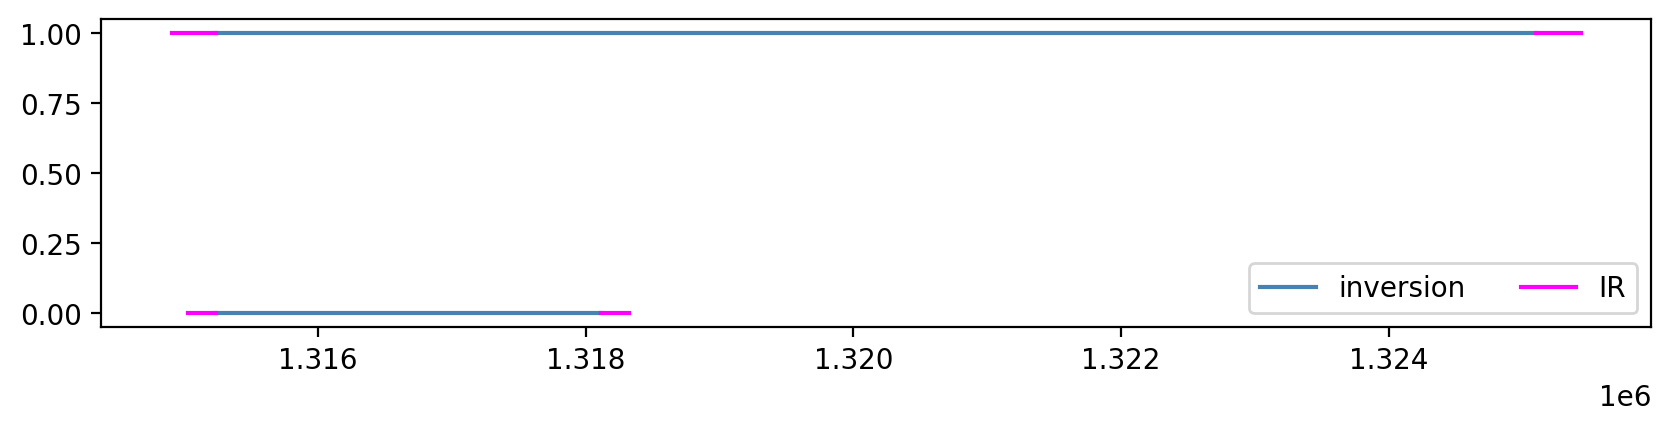

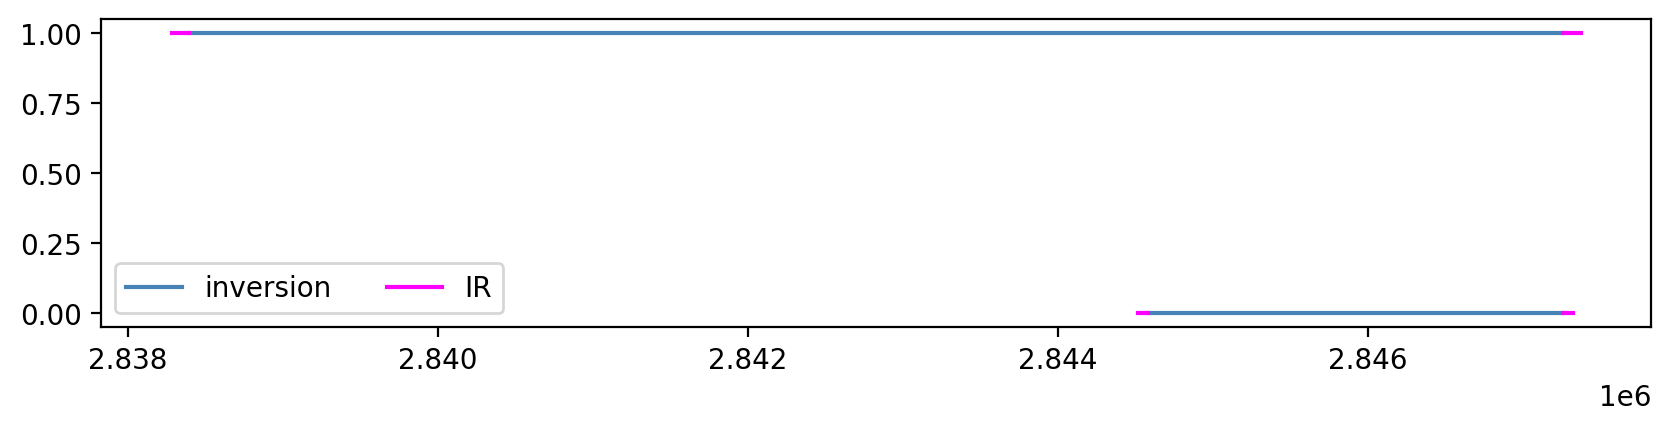

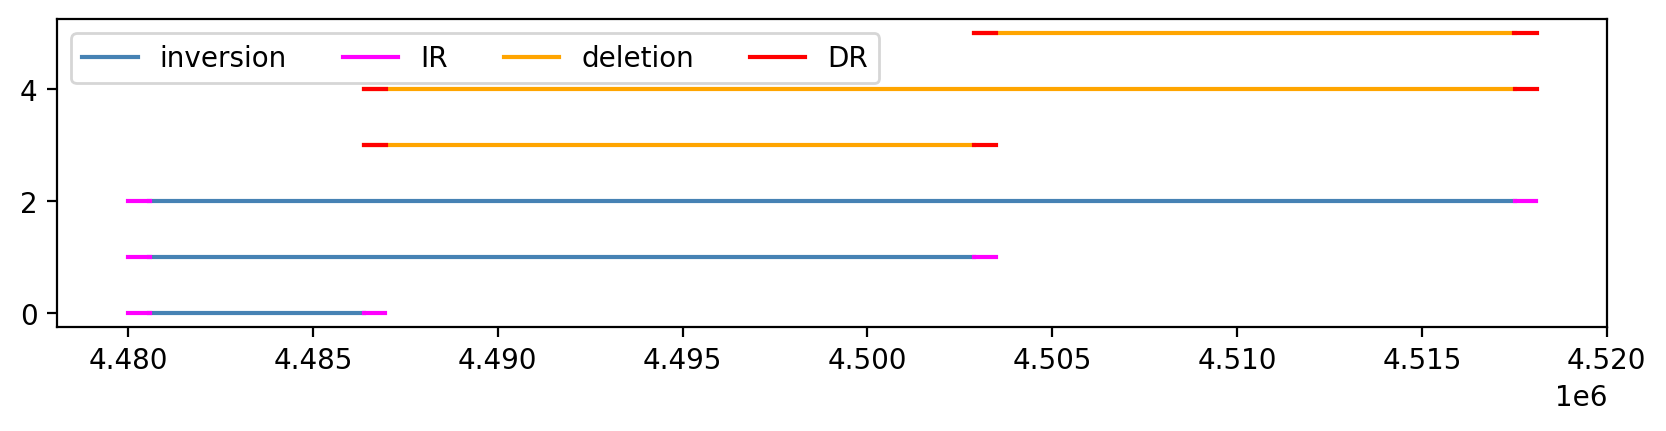

In [217]:
for inv in info_df["invertase"].unique():
    plt.figure(figsize=(10, 2), dpi=200)
    inv_df = info_df[info_df["invertase"] == inv]
    for i in range(inv_df.shape[0]):
        row = inv_df.iloc[i]
        type_ = row["type"]
        if type_ == "inv":
            plt.plot((row["start"], row["end"]), (i, i), c='steelblue', label="inversion")
        else:
            plt.plot((row["start"], row["end"]), (i, i), c='orange', label="deletion")
        
        if type_ == "inv":
            plt.plot((row["IR Coordinate A"], row["IR Coordinate B"]), (i, i), c="magenta", label="IR")
            plt.plot((row["IR Coordinate C"], row["IR Coordinate D"]), (i, i), c="magenta")
            
        if type_ == "del":
            plt.plot((row["DR Coordinate A"], row["DR Coordinate B"]), (i, i), c="red", label="DR")
            plt.plot((row["DR Coordinate C"], row["DR Coordinate D"]), (i, i), c="red")
        
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc="best", ncol=len(by_label))
        plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
        
        
    plt.show()

In [205]:
info_df.to_csv("btheta_large_sv_IRs_DRs.csv")

In [179]:
dr_dr_alignment_lengths = []

for d1 in info_df["DR1 Sequence"]:
    lengths = []
    for d2 in info_df["DR1 Sequence"]:
        alignment = aligner.align(d1, d2)
        length = alignment[0].length
        rel_length = length / max(len(d1), len(d2))
        lengths.append(rel_length)
    dr_dr_alignment_lengths.append(lengths)

In [180]:
dr_alignments = pd.DataFrame(dr_dr_alignment_lengths)
dr_alignments.index = info_df.index
dr_alignments.columns = info_df.index
dr_alignments

invertase                   BT_1041             BT_2267             BT_3478  \
start                       1315241             2844579   2838395   4480576   
end                         1318115   1325103   2847259   2847259   4486382   
invertase start   end                                                         
BT_1041   1315241 1318115  1.000000  0.200000  0.300000  0.300000  0.250000   
                  1325103  0.200000  1.000000  0.263158  0.263158  0.631579   
BT_2267   2844579 2847259  0.300000  0.263158  1.000000  0.894737  0.166667   
          2838395 2847259  0.300000  0.263158  0.894737  1.000000  0.157895   
BT_3478   4480576 4486382  0.250000  0.631579  0.166667  0.157895  1.000000   
                  4502881  0.150000  0.157895  0.117647  0.105263  0.222222   
                  4517514  0.300000  0.263158  0.235294  0.210526  0.388889   
          4486382 4502881  0.015280  0.010187  0.013582  0.013582  0.010187   
                  4517514  0.015126  0.010084  0.013445  0.013445  0.010084   
          4502875 4517514  0.011706  0.013378  0.011706  0.011706  0.026756   

invertase                                                                    
start                                           4486382             4502875  
end                         4502881   4517514   4502881   4517514   4517514  
invertase start   end                                                        
BT_1041   1315241 1318115  0.150000  0.300000  0.015280  0.015126  0.011706  
                  1325103  0.157895  0.263158  0.010187  0.010084  0.013378  
BT_2267   2844579 2847259  0.117647  0.235294  0.013582  0.013445  0.011706  
          2838395 2847259  0.105263  0.210526  0.013582  0.013445  0.011706  
BT_3478   4480576 4486382  0.222222  0.388889  0.010187  0.010084  0.026756  
                  4502881  1.000000  0.285714  0.010187  0.010084  0.010033  
                  4517514  0.285714  1.000000  0.010187  0.010084  0.013378  
          4486382 4502881  0.010187  0.010187  1.000000  0.989916  0.984950  
                  4517514  0.010084  0.010084  0.989916  1.000000  0.984950  
          4502875 4517514  0.010033  0.013378  0.984950  0.984950  1.000000

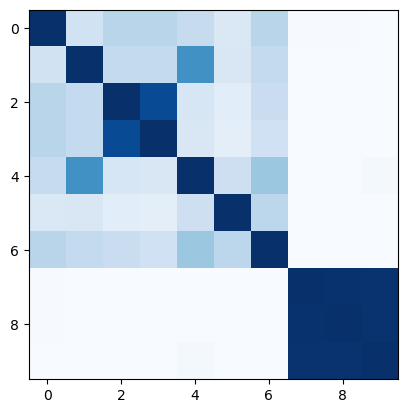

In [181]:
import matplotlib.pyplot as plt

thresh = 0.9

# plt.imshow(dr_alignments > thresh, cmap="Blues")
plt.imshow(dr_alignments, cmap="Blues")

In [176]:
ir_ir_alignment_lengths = []

for i1 in info_df["IR1 Sequence"]:
    lengths = []
    for i2, i22 in zip(info_df["IR1 Sequence"], info_df["IR2 Sequence"]):
        
        alignment = aligner.align(i1, i2)
        length = alignment[0].length
        rel_length = length / max(len(i1), len(i2))
        
        alignment = aligner.align(i1, i22)
        length = alignment[0].length
        rel_length = max(rel_length, length / max(len(i1), len(i2)))
        
        lengths.append(rel_length)
    ir_ir_alignment_lengths.append(lengths)

In [177]:
ir_alignments = pd.DataFrame(ir_ir_alignment_lengths)
ir_alignments.index = info_df.index
ir_alignments.columns = info_df.index
ir_alignments

invertase                   BT_1041             BT_2267             BT_3478  \
start                       1315241             2844579   2838395   4480576   
end                         1318115   1325103   2847259   2847259   4486382   
invertase start   end                                                         
BT_1041   1315241 1318115  1.000000  0.639640  0.042254  0.032864  0.013722   
                  1325103  0.639640  1.000000  0.048048  0.048048  0.017153   
BT_2267   2844579 2847259  0.032864  0.033033  1.000000  0.469027  0.027444   
          2838395 2847259  0.079812  0.051051  0.469027  1.000000  0.015437   
BT_3478   4480576 4486382  0.013722  0.017153  0.027444  0.018868  1.000000   
                  4502881  0.013423  0.016779  0.026846  0.018456  0.978188   
                  4517514  0.013746  0.017182  0.027491  0.018900  0.998285   
          4486382 4502881  0.037559  0.024024  0.076923  0.061947  0.017153   
                  4517514  0.042254  0.027027  0.076923  0.044248  0.013722   
          4502875 4517514  0.023474  0.015015  0.076923  0.061947  0.018868   

invertase                                                                    
start                                           4486382             4502875  
end                         4502881   4517514   4502881   4517514   4517514  
invertase start   end                                                        
BT_1041   1315241 1318115  0.018456  0.015464  0.042254  0.042254  0.051643  
                  1325103  0.016779  0.017182  0.027027  0.027027  0.033033  
BT_2267   2844579 2847259  0.026846  0.027491  0.076923  0.076923  0.092308  
          2838395 2847259  0.016779  0.017182  0.061947  0.044248  0.061947  
BT_3478   4480576 4486382  0.978188  0.998285  0.017153  0.013722  0.018868  
                  4502881  1.000000  0.976510  0.016779  0.013423  0.018456  
                  4517514  0.976510  1.000000  0.017182  0.013746  0.018900  
          4486382 4502881  0.016779  0.017182  1.000000  0.200000  0.200000  
                  4517514  0.011745  0.018900  0.200000  1.000000  0.214286  
          4502875 4517514  0.018456  0.018900  0.200000  0.214286  1.000000

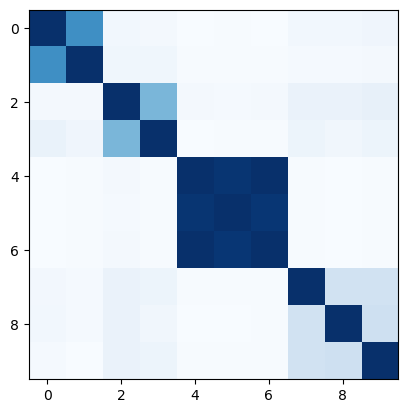

In [178]:
import matplotlib.pyplot as plt

plt.imshow(ir_alignments, cmap="Blues")